<a href="https://colab.research.google.com/github/Zhuoyue-Huang/urop_2022_ml/blob/main/FE_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
from torch.distributions.exponential import Exponential

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [32]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, x_dim, mask_val=0, device='cuda'):
    return torch.zeros(sample_num, x_dim, device=device).bernoulli_(prob)*(1-mask_val) + mask_val

def mask_probs(prob_list: torch.Tensor, sample_num, x_dim, mask_val=0, device='cuda'):
    return torch.zeros(sample_num, x_dim, device=device).bernoulli_(prob_list)*(1-mask_val) + mask_val

# def mask_patches_block(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor, device='cuda'):
#     x_dim = sample_dim[0]*sample_dim[1]
#     div_check = sample_dim % patch_size == torch.zeros(2)
#     if torch.all(div_check):
#         pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
#         mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob).to(device)
#         mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
#         return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, x_dim)
#     else:
#         raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")

def mask_patches_plain(prob, patch_size, sample_num, x_dim, mask_val=0, device='cuda'):
    if not x_dim % patch_size:
        pix_num = x_dim // patch_size
        mat_patches = torch.zeros(sample_num, pix_num).bernoulli_(prob)
        return mat_patches.repeat_interleave(patch_size, dim=1).to(device)*(1-mask_val) + mask_val
    else:
        raise NotImplementedError

In [33]:
def feature_extraction(data_dict, f_dim, criterion, model_type, prob=None, prob_list=None, patch_size=None, mask_val=0, device='cuda'):
    X_train, _, X_val, _, _, _ = data_dict.values()
    train_num, x_dim = X_train.shape
    val_num = X_val.shape[0]
    if model_type == 'LAE':
        Sigma = X_train.T @ X_train
        U, _, _ = torch.linalg.svd(Sigma)
        U = U[:, :f_dim]
        W1 = U.T 
        W2 = U
        loss = criterion(X_val@W1.T@W2.T, X_val)
    else:
        X = X_train
        if prob == 1 or mask_val==1:
            Sigma = X.T@X
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T
            W2 = U
            loss = criterion(X_val@W1.T@W2.T, X_val)
        else:
            mask_dict = {}
            if model_type == 'MLAE_basic':
                first_moment = prob + mask_val * (1-prob)
                second_moment = prob + mask_val**2 * (1-prob)
                mask_dict['mean'] = (torch.ones(train_num, x_dim, device=device) * first_moment)
                mask_dict['square'] = torch.ones(x_dim, x_dim, device=device) * first_moment**2
                mask_dict['square'].fill_diagonal_(second_moment)
            elif model_type == 'MLAE_probs':
                first_moment = prob_list + mask_val * (1-prob_list)
                second_moment = prob_list + mask_val**2 * (1-prob_list)
                mask_dict['mean'] = first_moment.repeat(train_num, 1).to(device)
                mask_dict['square'] = first_moment.view(x_dim, 1) @ first_moment.view(1, x_dim)
                mask_dict['square'] = (mask_dict['square'].fill_diagonal_(0) + torch.diag(second_moment)).to(device)
            elif model_type == 'MLAE_patches':
                first_moment = prob + mask_val * (1-prob)
                second_moment = prob + mask_val**2 * (1-prob)
                mask_dict['mean'] = torch.ones(train_num, x_dim, device=device) * first_moment
                # plain patches
                patch_block_mat = torch.ones(patch_size, patch_size, device=device)
                mask_dict['square'] = torch.block_diag(*[patch_block_mat]*(x_dim//patch_size))*(second_moment-first_moment**2) + first_moment**2
                # block patches
                # patch_size = [2, 2]
                # pix_num = torch.div(torch.tensor(sample_dim), torch.tensor(patch_size), rounding_mode='floor')
                # mat_patches = torch.arange(pix_num[0]*pix_num[1]).view(*pix_num)
                # mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=1)
                # mat_patches = torch.repeat_interleave(mat_patches, patch_size[0], dim=0).view(n)
                # mask_dict['square'] = torch.zeros(x_dim, x_dim)
                # for i in range(x_dim):
                #     for j in range(x_dim):
                #         if mat_patches[i] == mat_patches[j]:
                #             mask_dict['square'][i, j] = prob
                #         else:
                #             mask_dict['square'][i, j] = prob**2
            try:
                torch.inverse(mask_dict['square'] * (X.T @ X))
            except torch._C._LinAlgError:
                # Sigma_XX = X.T@X
                # U_XX, S_XX, Vh_XX = torch.linalg.svd(Sigma_XX)
                # print(S_XX)
                # inv = Vh_XX.T*torch.inverse(torch.diag(S_XX+1e-4))*U_XX.T

                perturbation = torch.diag(torch.ones(x_dim, device=device)*1e-5)
                inv = torch.inverse(mask_dict['square']*(X.T@X) + perturbation)
            else:
                inv = torch.inverse(mask_dict['square'] * (X.T @ X))
            Sigma = X.T@(mask_dict['mean']*X) @ inv @ ((mask_dict['mean']*X).T@X)
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T @ (X.T@(mask_dict['mean']*X)) @ inv
            W2 = U
            if model_type == 'MLAE_basic':
                loss = criterion((mask_basic(prob, val_num, x_dim, mask_val=mask_val)*X_val)@W1.T@W2.T, X_val)
            elif model_type == 'MLAE_probs':
                loss = criterion((mask_probs(prob_list, val_num, x_dim, mask_val=mask_val)*X_val)@W1.T@W2.T, X_val)
            elif model_type == 'MLAE_patches':
                loss = criterion((mask_patches_plain(prob, patch_size, val_num, x_dim, mask_val=mask_val)*X_val)@W1.T@W2.T, X_val)
    return (W1, loss.cpu().item())

In [34]:
# representation learning
def repr_learning(data_dict, W1, criterion, reg_coeff=0, device='cuda'):
    X_train, y_train, _, _, X_test, y_test = data_dict.values()

    f_train = X_train @ W1.T
    f_test = X_test @ W1.T
    f_dim = f_train.shape[1]
    y_dim = y_train.shape[1]

    theta = (torch.inverse(f_train.T@f_train+reg_coeff*torch.eye(f_dim, device=device)) @ f_train.T @ y_train).T
    loss = criterion(y_test, f_test @ theta.T)
    return loss.item()

### Dataset

In [35]:
train_num, val_num, test_num = (4000, 500, 2000) # larger number of dataset
sample_num_split = (train_num, train_num + val_num)
total = train_num+val_num+test_num

# need to consider f_dim <, =, > z_dim
z_dim = 30 # dimension of z
H = 8
W = 8
sample_dim = torch.tensor([H, W])
x_dim = H * W
f_dim = 45
y_dim = z_dim // 2

prob_search = torch.arange(0.05, 1+0.01, 0.05)
prob_list_search = torch.rand(x_dim, generator=torch.random.manual_seed(1911))*0.1 + torch.repeat_interleave(torch.arange(0.05, 0.9+0.01, 0.05).unsqueeze(1), x_dim, dim=1)
patch_size_plain_search = torch.tensor([1, 2, 4, 8, 16])
# patch_size_block_search = []
# for i in [1, 2, 4, 8, 16]:
#     for j in [1, 2, 4, 8, 16]:
#         patch_size_block_search.append([i, j])
# patch_size_search = torch.tensor(patch_size_block_search)

In [36]:
#mean = torch.linspace(0, 5, z_dim).repeat(total, 1)
#std = torch.linspace(3, 8, z_dim).repeat(total, 1)
#m = Exponential(1)
#z = m.rsample((total,z_dim))
#z = torch.normal(mean=mean, std=std, generator=torch.random.manual_seed(1911))
z = torch.normal(mean=0, std=1, size=(total,z_dim), generator=torch.random.manual_seed(1911))# here distribution is high dimensional guassian
z = z.to(device)

In [37]:
U = torch.rand(x_dim, z_dim, generator=torch.random.manual_seed(1911))
U = U.to(device)
V = torch.rand(y_dim, z_dim, generator=torch.random.manual_seed(1911))
V = V.to(device)

x = z @ U.T
y = z @ V.T
X_train, X_val, X_test = torch.tensor_split(x, sample_num_split)
y_train, y_val, y_test = torch.tensor_split(y, sample_num_split)
data_dict = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
#fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [38]:
criterion = nn.MSELoss()
rand_epoch = 50
reg_coeff = 1
mask_val = 2

### Get features from autoencoder

##### Linear autoencoder

In [39]:
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='LAE')
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion, reg_coeff=reg_coeff)
print('representation learning loss:', rl_loss)

feature extraction loss: 4.1734895734989276e-26
representation learning loss: 1.0995967752072981e-08


In [40]:
#print('mean:', statistics.mean(fe_loss_dict['LAE']), ', sd:', statistics.stdev(fe_loss_dict['LAE']))

##### Masked linear autoencoder (basic)

In [41]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    total_loss = 0
    for i in range(rand_epoch):
        W1, loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_basic', prob=prob, mask_val=mask_val)
        total_loss += loss
    loss = total_loss / rand_epoch
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob

100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


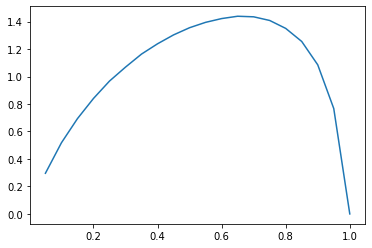

In [42]:
# search check
plt.plot(prob_search, search_score)

In [43]:
#search_score

In [44]:
prob = search_record['params']
print('prob:', prob.item(), '\nloss:', loss)

prob: 1.0 
loss: 4.1734895734989304e-26


In [45]:
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_basic', prob=prob, mask_val=mask_val)
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion, reg_coeff=reg_coeff)
print('representation learning loss:', rl_loss)

feature extraction loss: 4.1734895734989276e-26
representation learning loss: 1.0995967752072981e-08


In [46]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_basic']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_basic']))

##### Masked linear autoencoder (probs)

In [47]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob_list in tqdm(prob_list_search):
    total_loss = 0
    for i in range(rand_epoch):
        W1, loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_probs', prob_list=prob_list, mask_val=mask_val)
        total_loss += loss
    loss = total_loss / rand_epoch
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob_list

100%|██████████| 18/18 [00:05<00:00,  3.20it/s]


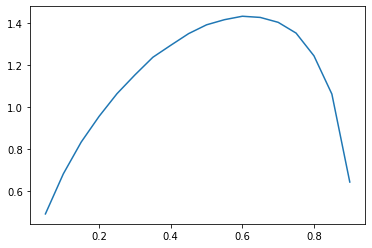

In [48]:
# search check
plt.plot(list(prob_search)[:18], search_score)

In [49]:
prob_list = search_record['params']
print('prob:', prob_list, '\nloss:', loss)

prob: tensor([0.1215, 0.1014, 0.0907, 0.0822, 0.0801, 0.0734, 0.1334, 0.1084, 0.0925,
        0.0720, 0.0551, 0.0959, 0.1185, 0.0857, 0.0935, 0.1455, 0.1360, 0.0765,
        0.0561, 0.1301, 0.1259, 0.0734, 0.1109, 0.0873, 0.0502, 0.1049, 0.0997,
        0.0730, 0.0686, 0.0630, 0.1127, 0.0831, 0.1083, 0.0862, 0.1440, 0.0845,
        0.1491, 0.1099, 0.1183, 0.0918, 0.1366, 0.0862, 0.1211, 0.1416, 0.0963,
        0.0906, 0.1256, 0.0996, 0.0963, 0.0709, 0.0878, 0.0831, 0.0914, 0.0902,
        0.1119, 0.0694, 0.0657, 0.1268, 0.0669, 0.1356, 0.0597, 0.1394, 0.1129,
        0.1251]) 
loss: 0.6426980393095867


In [50]:
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_probs', prob_list=prob_list, mask_val=mask_val)
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion, reg_coeff=reg_coeff)
print('representation learning loss:', rl_loss)

feature extraction loss: 0.5066407304065097
representation learning loss: 5.697675358245308e-06


In [51]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_probs']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_probs']))

##### Masked linear autoencoder (patches)

In [52]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    for patch_size in patch_size_plain_search:
        total_loss = 0
        for i in range(rand_epoch):
            W1, loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_patches', prob=prob, patch_size=patch_size, mask_val=mask_val)
            total_loss += loss
        loss = total_loss / rand_epoch
        search_score.append(loss)
        if loss < search_record['best_score']:
            search_record['best_score'] = loss
            search_record['params'] = (prob, patch_size)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


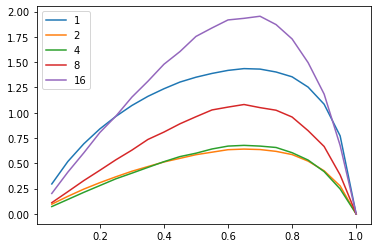

In [53]:
# search check
for i in range(5):
    plt.plot(prob_search, search_score[i::5])
plt.legend([str(patch_size.item()) for patch_size in patch_size_plain_search])

In [54]:
prob, patch_size = search_record['params']
print('prob:', prob, ',\npatch_size:', patch_size.item(), ',\nloss:', loss)

prob: tensor(1.) ,
patch_size: 1 ,
loss: 4.1734895734989304e-26


In [55]:
# feature extraction
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_patches', prob=prob, patch_size=patch_size, mask_val=mask_val)
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion, reg_coeff=reg_coeff)
print('representation learning loss:', rl_loss)

feature extraction loss: 4.1734895734989276e-26
representation learning loss: 1.0995967752072981e-08


In [56]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_patches']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_patches']))

### Evaluation